# 再次调整弱分类器数目n_estimators 

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [2]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"RentListingInquries_FE_train.csv")
# train.head()

## 准备数据

In [3]:
y_train = train['interest_level']

train = train.drop(['interest_level'], axis=1, inplace = False)
X_train = train

In [4]:
# 训练样本6w+，交叉验证太慢，用train_test_split估计模型性能
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.2,random_state = 0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
X_train_part.shape

(9870, 227)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [6]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

再次调整弱分类器数目

In [7]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 9
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
                         metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        
        n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators = n_estimators)
        
        print (cvresult)
        #result = pd.DataFrame(cvresult)   #cv缺省返回结果为DataFrame
        #result.to_csv('my_preds.csv', index_label = 'n_estimators')
        cvresult.to_csv('my_preds4_2_3_699.csv', index_label = 'n_estimators')
        
        # plot
        test_means = cvresult['test-mlogloss-mean']
        test_stds = cvresult['test-mlogloss-std'] 
        
        train_means = cvresult['train-mlogloss-mean']
        train_stds = cvresult['train-mlogloss-std'] 

        x_axis = range(0, n_estimators)
        pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
        pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
        pyplot.title("XGBoost n_estimators vs Log Loss")
        pyplot.xlabel( 'n_estimators' )
        pyplot.ylabel( 'Log Loss' )
        pyplot.savefig( 'n_estimators4_2_3_699.png' )
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

        
    #Print model report:
    print ('logloss of train :' )
    print (logloss)

     train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0               1.954303            0.001869            1.961597   
1               1.777775            0.002509            1.792024   
2               1.637797            0.004751            1.658035   
3               1.523091            0.004554            1.548237   
4               1.425891            0.005277            1.454989   
5               1.341796            0.004756            1.375528   
6               1.269345            0.005882            1.306226   
7               1.203623            0.006282            1.245136   
8               1.146978            0.006021            1.192566   
9               1.095797            0.006319            1.144731   
10              1.049504            0.005939            1.102781   
11              1.008500            0.005431            1.064910   
12              0.970954            0.005918            1.031250   
13              0.937006            0.005852    

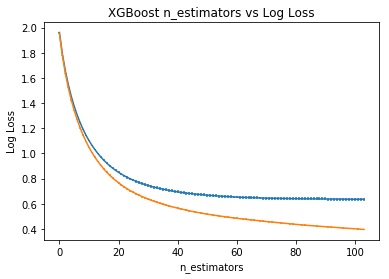

In [8]:
#调整max_depth和min_child_weight之后再次调整n_estimators(6,4)
xgb2_3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=699,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=6,
        min_child_weight=3,
        gamma=0,
        subsample=0.5,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb2_3, X_train_part, y_train_part, cv_folds = kfold)

In [10]:
# from sklearn.model_selection import cross_val_score
# results = cross_val_score(xgb2_3, X_train, y_train, metrics='mlogloss', cv=kfold)
# print (results)
# print("CV logloss: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


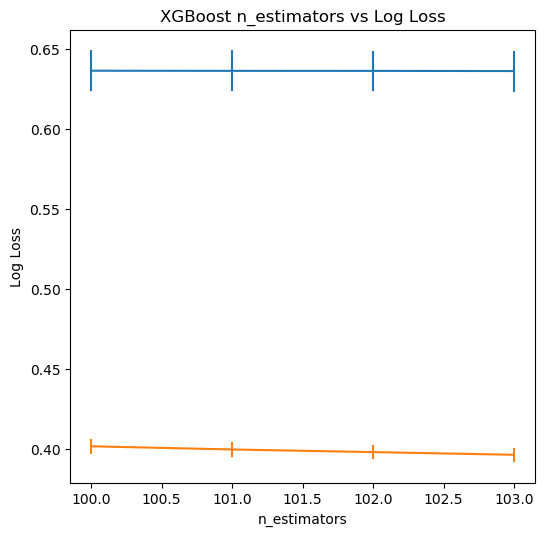

In [12]:
cvresult = pd.DataFrame.from_csv('my_preds4_2_3_699.csv')

cvresult = cvresult.iloc[100:]
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(100,cvresult.shape[0]+100)
        
fig = pyplot.figure(figsize=(6, 6), dpi=100)
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators_detail4_2_3_699.png' )

pyplot.show()

当前参数调整得到的n_estimators最优值为103。